<a href="https://colab.research.google.com/github/HakureiPOI/llm-stockrec/blob/main/notebook/validlogic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HakureiPOI

---

## Part1.获取数据

通过 akshare 获取 k 线数据

In [1]:
!pip install akshare -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 69.2 MB/s eta 0:00:00


In [2]:
import akshare as ak
import numpy as np
import pandas as pd

In [3]:
# fetch 600030 (中信证券) 的历史行情数据
stock_df = ak.stock_zh_a_hist(symbol="600030", period="daily", start_date="20200101", adjust="qfq")
display(stock_df.tail())

,日期,股票代码,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
1455,2026-01-13,600030,28.85,28.55,29.15,28.48,2159691,6.226327e+09,2.33,-0.80,-0.23,1.77
1456,2026-01-14,600030,28.49,28.23,29.13,28.15,3218823,9.209656e+09,3.43,-1.12,-0.32,2.64
1457,2026-01-15,600030,28.38,28.28,28.80,28.23,2078141,5.904892e+09,2.02,0.18,0.05,1.71
1458,2026-01-16,600030,28.50,28.08,28.57,27.99,2095813,5.914162e+09,2.05,-0.71,-0.20,1.72
1459,2026-01-19,600030,27.74,27.74,27.97,27.70,988150,2.748609e+09,0.96,-1.21,-0.34,0.81


In [4]:
# Convert '日期' to datetime
stock_df['日期'] = pd.to_datetime(stock_df['日期'])

# Rename columns to English
column_mapping = {
    "日期": "date",
    "股票代码": "symbol",
    "开盘": "open",
    "收盘": "close",
    "最高": "high",
    "最低": "low",
    "成交量": "volume",
    "成交额": "amount",
    "振幅": "amplitude",
    "涨跌幅": "pct_chg",
    "涨跌额": "change",
    "换手率": "turnover"
}
stock_df.rename(columns=column_mapping, inplace=True)

# Set 'date' as index
stock_df.set_index('date', inplace=True)

display(stock_df.tail())

,symbol,open,close,high,low,volume,amount,amplitude,pct_chg,change,turnover
date,,,,,,,,,,,
2026-01-13,600030,28.85,28.55,29.15,28.48,2159691,6.226327e+09,2.33,-0.80,-0.23,1.77
2026-01-14,600030,28.49,28.23,29.13,28.15,3218823,9.209656e+09,3.43,-1.12,-0.32,2.64
2026-01-15,600030,28.38,28.28,28.80,28.23,2078141,5.904892e+09,2.02,0.18,0.05,1.71
2026-01-16,600030,28.50,28.08,28.57,27.99,2095813,5.914162e+09,2.05,-0.71,-0.20,1.72
2026-01-19,600030,27.74,27.74,27.97,27.70,988150,2.748609e+09,0.96,-1.21,-0.34,0.81


---

## Part2.计算技术指标，特征工程，标签

In [5]:
# 1. Moving Averages (均线)
stock_df['ma5'] = stock_df['close'].rolling(window=5).mean()
stock_df['ma10'] = stock_df['close'].rolling(window=10).mean()
stock_df['ma20'] = stock_df['close'].rolling(window=20).mean()

# 2. RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_df['rsi'] = calculate_rsi(stock_df['close'])

# 3. MACD
# EMA 12
exp1 = stock_df['close'].ewm(span=12, adjust=False).mean()
# EMA 26
exp2 = stock_df['close'].ewm(span=26, adjust=False).mean()
stock_df['macd'] = exp1 - exp2
stock_df['macd_signal'] = stock_df['macd'].ewm(span=9, adjust=False).mean()

# 4. Volatility (Rolling Standard Deviation)
stock_df['volatility'] = stock_df['close'].rolling(window=20).std()

# 5. ATR (Average True Range)
# Calculate True Range (TR)
high_low = stock_df['high'] - stock_df['low']
high_close = np.abs(stock_df['high'] - stock_df['close'].shift())
low_close = np.abs(stock_df['low'] - stock_df['close'].shift())

tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
stock_df['atr'] = tr.rolling(window=14).mean()

# 6. Daily Return
stock_df['daily_return'] = stock_df['close'].pct_change()

stock_df.dropna(inplace=True)
display(stock_df[['close', 'ma5', 'ma20', 'rsi', 'macd', 'atr', 'volatility']].tail())

,close,ma5,ma20,rsi,macd,atr,volatility
date,,,,,,,
2026-01-13,28.55,28.788,28.8615,48.883929,0.107930,0.513571,0.416189
2026-01-14,28.23,28.534,28.8455,45.815900,0.049341,0.562857,0.434541
2026-01-15,28.28,28.482,28.8355,45.127119,0.006865,0.583571,0.445557
2026-01-16,28.08,28.384,28.7910,40.638298,-0.042447,0.602143,0.474895
2026-01-19,27.74,28.176,28.7515,36.122449,-0.107721,0.593571,0.527669


In [6]:
HORIZON = 5

# 时间平方根法则
volatility_threshold = stock_df['daily_return'].std() * np.sqrt(HORIZON) * 1.0
print(f"Defined 'Big' trend threshold (over {HORIZON} days) as: {volatility_threshold*100:.2f}%")

# Prepare Future Data
stock_df['future_close'] = stock_df['close'].shift(-HORIZON)
# Max high over the next N days
stock_df['future_high_max'] = stock_df['high'].rolling(window=HORIZON).max().shift(-HORIZON)
# Min low over the next N days
stock_df['future_low_min'] = stock_df['low'].rolling(window=HORIZON).min().shift(-HORIZON)

# Future Return，即未来相对于当前的涨幅
stock_df['future_return'] = stock_df['future_close'] / stock_df['close'] - 1.0

# --- Target 1: Trend Up (趋势涨) ---
stock_df['target_trend_up'] = (stock_df['future_return'] > 0).astype(int)

# --- Target 2: High Volatility (趋势大波动) ---
stock_df['target_trend_volatile'] = (stock_df['future_return'].abs() > volatility_threshold).astype(int)

# --- Target 3: Big Drop (趋势大跌) ---
stock_df['target_trend_big_drop'] = (stock_df['future_return'] < -volatility_threshold).astype(int)

# --- Target 4: Big Rise (趋势大涨) ---
stock_df['target_trend_big_rise'] = (stock_df['future_return'] > volatility_threshold).astype(int)

# --- Target 5: Break Recent Low (向下突破) ---
recent_low = stock_df['low'].rolling(window=5).min()
stock_df['target_break_low'] = (stock_df['future_low_min'] < recent_low).astype(int)

# --- Target 6: Break Recent High (向上突破) ---
recent_high = stock_df['high'].rolling(window=5).max()
stock_df['target_break_high'] = (stock_df['future_high_max'] > recent_high).astype(int)

stock_df.dropna(inplace=True)
target_cols = ['target_trend_up', 'target_trend_volatile', 'target_trend_big_drop', 'target_trend_big_rise', 'target_break_low', 'target_break_high']

print(f"Target Distribution (Horizon={HORIZON} days):")
print(stock_df[target_cols].mean())

Defined 'Big' trend threshold (over 5 days) as: 4.44%
Target Distribution (Horizon=5 days):
target_trend_up          0.485376
target_trend_volatile    0.213788
target_trend_big_drop    0.103760
target_trend_big_rise    0.110028
target_break_low         0.474930
target_break_high        0.455432
dtype: float64


In [7]:
!pip install mplfinance -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.6 MB/s eta 0:00:00


In [8]:
import mplfinance as mpf

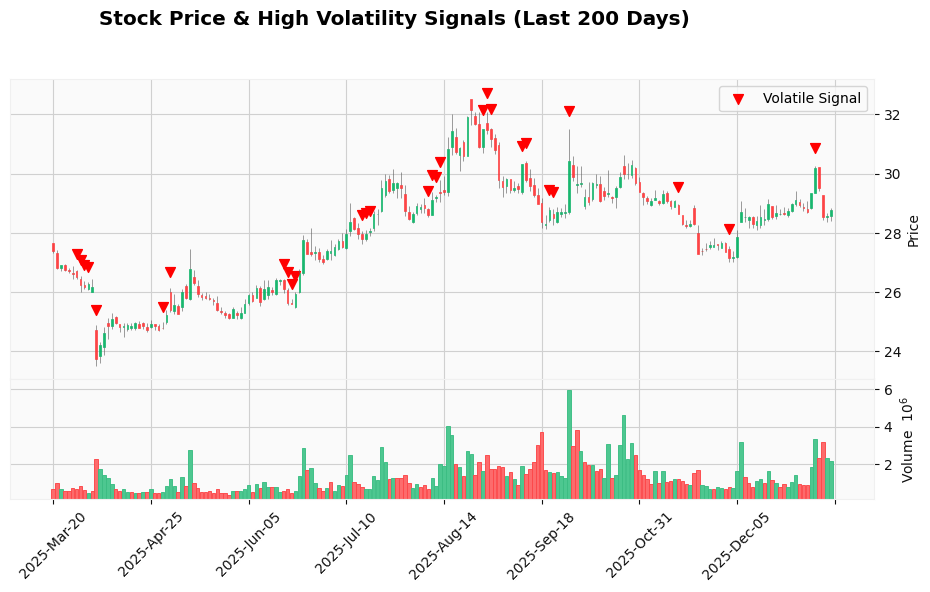

In [9]:

plot_df = stock_df.tail(200).copy()
plot_df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

signal = np.full(len(plot_df), np.nan)

volatile_indices = plot_df['target_trend_volatile'] == 1

signal[volatile_indices] = plot_df.loc[volatile_indices, 'High'] * 1.02

ap = mpf.make_addplot(signal, type='scatter', markersize=50, marker='v', color='r', label='Volatile Signal')


mpf.plot(plot_df, type='candle', style='yahoo', addplot=ap,
         title='Stock Price & High Volatility Signals (Last 200 Days)',
         ylabel='Price', volume=True, figsize=(12, 6))

---

## Part3.训练模型

In [10]:
!pip install lightgbm -q

In [11]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
features = ['ma5', 'ma10', 'ma20', 'rsi', 'macd', 'macd_signal', 'atr', 'volatility', 'daily_return']
targets = ['target_trend_up', 'target_trend_volatile', 'target_trend_big_drop', 'target_trend_big_rise', 'target_break_low', 'target_break_high']

split_idx = int(len(stock_df) * 0.8)

X_train = stock_df[features].iloc[:split_idx]
X_test = stock_df[features].iloc[split_idx:]

results = []
models = {}

print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")
print("-" * 80)

for target in targets:
    y_train = stock_df[target].iloc[:split_idx]
    y_test = stock_df[target].iloc[split_idx:]

    # Initialize and Train LightGBM
    # Class weight='balanced' is crucial for imbalanced targets (like Big Drop)
    clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42, verbose=-1, class_weight='balanced')
    clf.fit(X_train, y_train)
    models[target] = clf

    # Predict
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, y_prob)
    except ValueError:
        auc = 0.5

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'Target': target,
        'AUC': auc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Pos Samples': y_test.sum()
    })


results_df = pd.DataFrame(results)
results_df.sort_values(by='AUC', ascending=False, inplace=True)

print("\nSummary of Model Performance (Ranked by AUC):")

display_df = results_df.copy()
for col in ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2%}" if col != 'AUC' and col != 'F1-Score' else f"{x:.4f}")
display(display_df)

Training set size: 1148, Test set size: 288
--------------------------------------------------------------------------------

Summary of Model Performance (Ranked by AUC):


,Target,AUC,Accuracy,Precision,Recall,F1-Score,Pos Samples
4,target_break_low,0.5968,55.21%,49.23%,76.19%,0.5981,126
5,target_break_high,0.5550,59.38%,61.19%,31.06%,0.4121,132
1,target_trend_volatile,0.5215,42.71%,14.20%,54.55%,0.2254,44
0,target_trend_up,0.4329,42.36%,43.10%,52.82%,0.4747,142
2,target_trend_big_drop,0.4207,80.21%,0.00%,0.00%,0.0000,24
3,target_trend_big_rise,0.4110,85.76%,11.11%,15.00%,0.1277,20



Analyzing the Best Performing Model: target_break_low
--------------------------------------------------


<Figure size 1000x500 with 0 Axes>

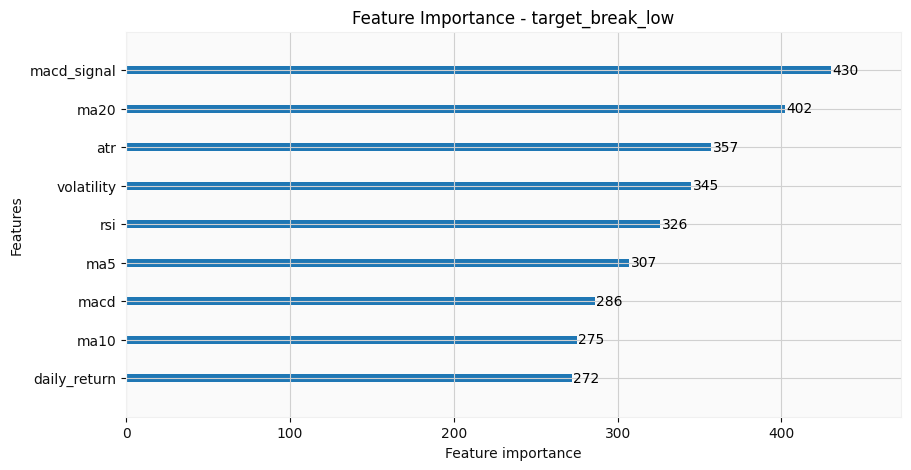

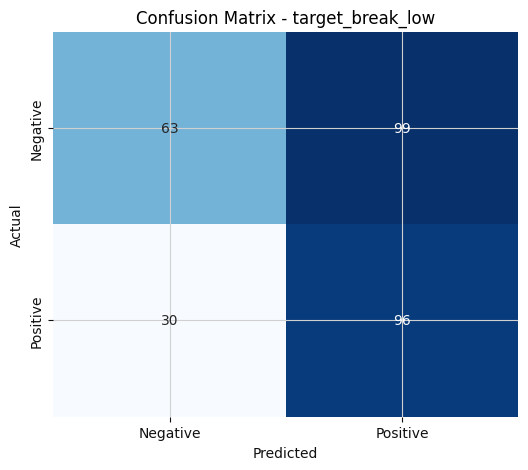

In [13]:
best_target = results_df.iloc[0]['Target']
print(f"\nAnalyzing the Best Performing Model: {best_target}")
print("-" * 50)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
lgb.plot_importance(models[best_target], max_num_features=10, figsize=(10, 5), title=f'Feature Importance - {best_target}')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(stock_df[best_target].iloc[split_idx:], models[best_target].predict(X_test))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_target}')
plt.show()